# Modeling

General Steps in Modeling

1. Algorithm Selection
2. Fit the models -- turning an algorithm into a model for our specific dataset
    - Linear regression is $y = mx + b$
    - Our model is $\text{final_grade} = 1.3 \times \text{exam1} + 12$
    - we "learn" the coefficients from the training data
3. Predict + Evaluate
4. Repeat
5. Take the best model and use it on the test set to see if we **overfit**

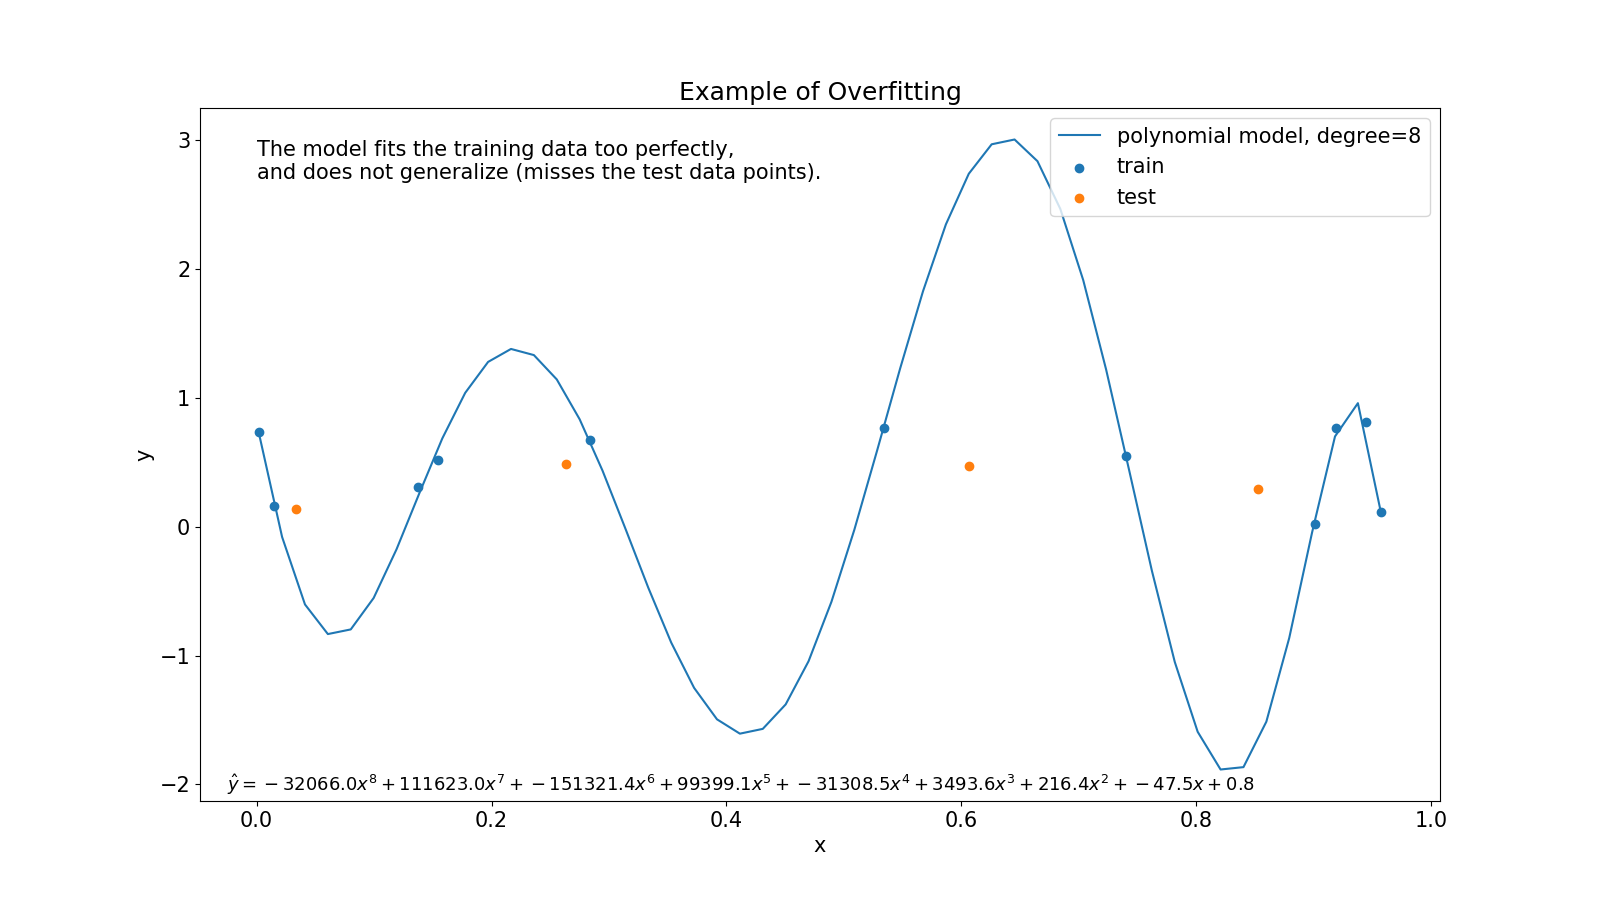

## Setup

In [1]:
import numpy as np
import pandas as pd
import wrangle
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def wrangle_grades():
    '''
    Read student_grades csv file into a pandas DataFrame,
    drop student_id column, replace whitespaces with NaN values,
    drop any rows with Null values, convert all columns to int64,
    return cleaned student grades DataFrame.
    '''
    # Acquire data from csv file.
    file = "https://gist.githubusercontent.com/ryanorsinger/14c8f919920e111f53c6d2c3a3af7e70/raw/07f6e8004fa171638d6d599cfbf0513f6f60b9e8/student_grades.csv"

    grades = pd.read_csv(file)

    # Replace white space values with NaN values.
    grades = grades.replace(r'^\s*$', np.nan, regex=True)

    # Drop all rows with NaN values.
    df = grades.dropna()

    # Convert all columns to int64 data types.
    df = df.astype('int')

    # Perform a train, validate, test split
    train_validate, test = train_test_split(df, random_state=123, train_size=.8)
    train, validate = train_test_split(train_validate, random_state=123, train_size=.7)
    
    return train, validate, test

train, validate, test = wrangle_grades() 

In [2]:
predictions = pd.DataFrame({
    'actual': validate.final_grade
}) 

In [3]:
predictions.head()

,actual
34,77
85,76
102,65
68,85
18,81


## Simple Model

$$ y = mx + b $$

$$y = f(x)$$

In [4]:
from sklearn.linear_model import LinearRegression

# X must be 2-d
X_train = train[['exam1']]
# y can be 1-d
y_train = train.final_grade

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
X_validate = validate[['exam1']]
predictions['simple_lm'] = lm.predict(X_validate)

In [5]:
predictions.head()

,actual,simple_lm
34,77,75.258718
85,76,77.541086
102,65,65.368457
68,85,85.148979
18,81,82.105822


### Examine The Model

- **intercept**: Value we predict if x is 0. Depending on our x variables, this may not be valueable
- **coefficients**: define how our prediction changes as x changes. A one-unit increase in x causes our model to predict a `coef` unit change in y, holding all other independent variables constant

In [6]:
lm.coef_, lm.intercept_

(array([0.76078933]), 22.003464638095956)

In [7]:
print('final_grade = {:.3f} * exam1 + {:.3f}'.format(lm.coef_[0], lm.intercept_))

final_grade = 0.761 * exam1 + 22.003


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


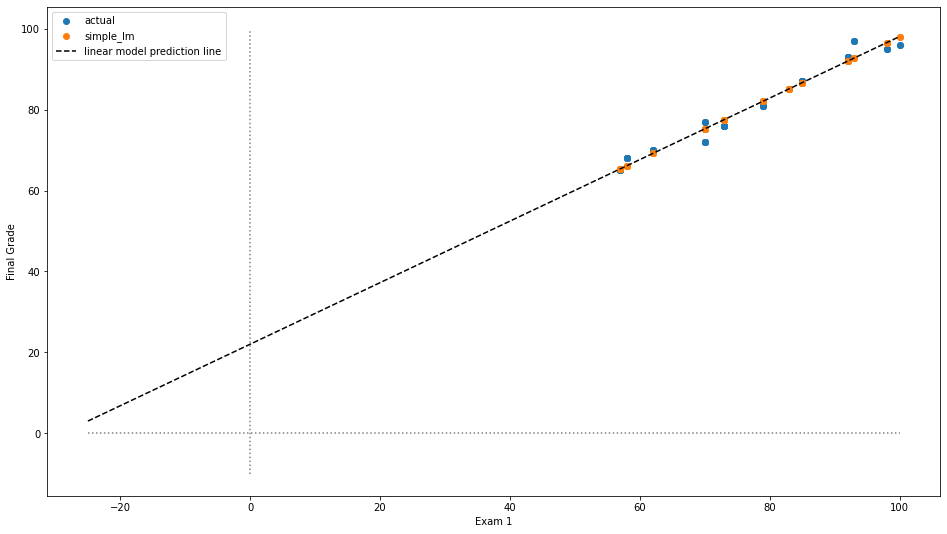

In [8]:
x_pred = np.array([-25, 100]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(16, 9))
plt.scatter(train.exam1, train.final_grade, label='actual')
plt.scatter(train.exam1, lm.predict(train[['exam1']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')

plt.xlabel('Exam 1')
plt.ylabel('Final Grade')
plt.legend()

### Model Interpretation

In [9]:
# final_grade = 0.761 * exam1 + 22.003
print(f'For every 1 point increase in Exam 1, we predict a {lm.coef_[0]:.2f} point increase in Final Grade')

For every 1 point increase in Exam 1, we predict a 0.76 point increase in Final Grade


In [10]:
exam1 = np.arange(90, 96)
final_grade = lm.predict(exam1.reshape(-1, 1))
pd.DataFrame(dict(exam1=exam1, predicted_final_grade=final_grade))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,exam1,predicted_final_grade
0,90,90.474505
1,91,91.235294
2,92,91.996083
3,93,92.756873
4,94,93.517662
5,95,94.278451


## Multiple Regression + RFE

$$ y = m_1x_1 + m_2x_2 + b $$

$$ y = f(x1, x2, ...) $$

In [11]:
X_train = train.drop(columns='final_grade')
y_train = train.final_grade
X_validate = validate.drop(columns='final_grade')

lm = LinearRegression()
k = 2

# 1. Transform our X
rfe = RFE(lm, n_features_to_select=2)
rfe.fit(X_train, y_train)
print('selected top 2 features:', X_train.columns[rfe.support_])
X_train_rfe = rfe.transform(X_train)

selected top 2 features: Index(['exam1', 'exam3'], dtype='object')


In [12]:
X_train.shape

(56, 4)

In [13]:
X_train_rfe.shape

(56, 2)

In [14]:
# 2. Use the transformed x in our model
lm.fit(X_train_rfe, y_train)

# 3. Make predictions
X_validate_rfe = rfe.transform(X_validate)
predictions['multiple_rfe'] = lm.predict(X_validate_rfe)

predictions.head()

,actual,simple_lm,multiple_rfe
34,77,75.258718,75.010191
85,76,77.541086,76.156010
102,65,65.368457,66.224523
68,85,85.148979,84.989751
18,81,82.105822,82.268101


### Examine the Model

In [15]:
X_train.columns[rfe.support_]

Index(['exam1', 'exam3'], dtype='object')

In [16]:
lm.coef_, lm.intercept_

(array([0.62071793, 0.23877836]), 12.935223897556597)

In [17]:
print(f'final_grade = {lm.coef_[0]:.2f} x exam1 + {lm.coef_[1]:.2f} x exam3 + {lm.intercept_:.2f}')

final_grade = 0.62 x exam1 + 0.24 x exam3 + 12.94


In [18]:
X = pd.DataFrame({
    'exam1': [80, 81, 82, 83, 84, 85, 85, 85, 85, 85, 85],
    'exam3': [80, 80, 80, 80, 80, 80, 81, 82, 83, 84, 85]
})

X['predicted_final_grade'] = lm.predict(X)
X

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


,exam1,exam3,predicted_final_grade
0,80,80,81.694927
1,81,80,82.315645
2,82,80,82.936363
3,83,80,83.557081
4,84,80,84.177799
5,85,80,84.798517
6,85,81,85.037295
7,85,82,85.276073
8,85,83,85.514852
9,85,84,85.753630


## Polynomial Features

First off...what the heck is a polynomial?

$$ y = a_0x^0 + a_1x^1 + a_2x^2 + ... + a_nx^n $$

or a simpler form:

$$ y = a_0 + a_1x + a_2x^2 + ... + a_nx^n $$

`degree = order = n`

What does a polynomial look like when graphed on a coordinate plane? Well it depends on
- The intercept
- The coefficients

Consider this third degree polynomial:

$$ y = 2x + x^3 $$

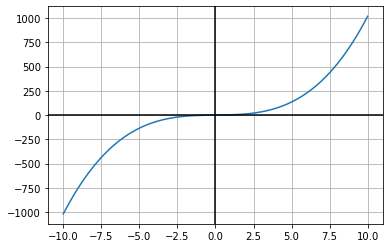

In [19]:
x = np.linspace(-10, 10, num=100)
fx = []
for i in range(len(x)):
    fx.append(2*x[i] + x[i]**3) # This could have also been done with list comprehension
    
plt.plot(x, fx)
plt.grid()
plt.axvline(color='black')
plt.axhline(color='black')
plt.show()

Let's try a different combination of intercept and coefficients:

$$ y = 1340 + 1.3x - 12x^2 + 0.5x^3 $$

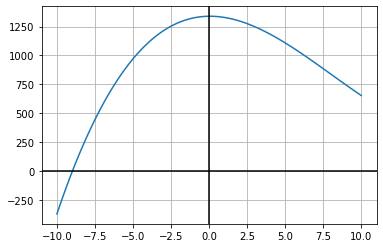

In [20]:
x = np.linspace(-10, 10, num=100)
fx = []
for i in range(len(x)):
    fx.append(1340 + 1.3*x[i] - 12*x[i]**2 + 0.5*x[i]**3) # This could have also been done with list comprehension
    
plt.plot(x, fx)
plt.grid()
plt.axvline(color='black')
plt.axhline(color='black')
plt.show()

If trying different intercepts and coefficients can produce a different shape of line, and we are looking for a line that minimizes error when fitting to training data...

Then we can use polynomial regression to make a curvilinear line of best fit! Finding that line of best fit just involves the magic of calculus.

With polynomial regression, we create very similar looking formulas:

$$ y = B_0 + B_1x + e $$

$$ y = B_0 + B_1x + B_2x^2 + e $$

$$ ... $$

$$ y = B_0 + B_1x + ... + B_kx^k + e $$


### Beware the **curse of dimensionality** and **combinatorial explosion**!

|   # Features |   Interaction Terms |   Total Terms (degree=2) |   Total Terms (degree=3) |
|-------------:|--------------------:|-------------------------:|-------------------------:|
|            1 |                   0 |                        2 |                        3 |
|            2 |                   1 |                        5 |                        9 |
|            3 |                   3 |                        9 |                       19 |
|            4 |                   6 |                       14 |                       34 |
|            5 |                  10 |                       20 |                       55 |
|            6 |                  15 |                       27 |                       83 |
|            7 |                  21 |                       35 |                      119 |

- degree = 2, single x
    $$ y = ax^2 + bx + c $$
- degree = 3, single x
    $$ y = ax^3 + bx^2 + cx + d $$
- degree = 2, x0 + x1
    $$ y = x_0^2 + x_0x_1 + x_1^2 + x_0 + x_1 $$

In [21]:
from sklearn.preprocessing import PolynomialFeatures

X_train = train[['exam1', 'exam2', 'exam3']]
X_validate = validate[['exam1', 'exam2', 'exam3']]
y_train = train.final_grade
y_validate = validate.final_grade

# 1. Generate Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)
X_train_poly.head()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,exam1,exam2,exam3,exam1^2,exam1 exam2,exam1 exam3,exam2^2,exam2 exam3,exam3^2
51,70.0,75.0,78.0,4900.0,5250.0,5460.0,5625.0,5850.0,6084.0
24,57.0,65.0,75.0,3249.0,3705.0,4275.0,4225.0,4875.0,5625.0
57,79.0,70.0,85.0,6241.0,5530.0,6715.0,4900.0,5950.0,7225.0
92,98.0,93.0,96.0,9604.0,9114.0,9408.0,8649.0,8928.0,9216.0
81,83.0,80.0,86.0,6889.0,6640.0,7138.0,6400.0,6880.0,7396.0


In [22]:
# 2. Use the features
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate)
predictions['polynomial degree 2'] = lm.predict(X_validate_poly)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [23]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2
34,77,75.258718,75.010191,76.744705
85,76,77.541086,76.156010,76.204728
102,65,65.368457,66.224523,65.652815
68,85,85.148979,84.989751,85.671647
18,81,82.105822,82.268101,81.009522


Examine the coefficients of the resulting model.

In [24]:
feature_names = poly.get_feature_names(X_train.columns)
pd.Series(lm.coef_, index=feature_names).sort_values()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


exam2         -3.249277
exam1         -0.388503
exam3^2       -0.152562
exam2^2       -0.104607
exam1^2       -0.034233
exam1 exam2   -0.004971
exam1 exam3    0.079904
exam2 exam3    0.229143
exam3          2.506270
dtype: float64

Another model with only interaction terms

In [25]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X.columns),
    index=train.index,
)
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate)
predictions['polynomial only interaction'] = lm.predict(X_validate_poly)

pd.Series(lm.coef_, index=poly.get_feature_names(X_train.columns)).sort_values()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


exam3         -3.565244
exam2         -2.436096
exam1 exam2   -0.028204
exam1 exam3   -0.001505
exam2 exam3    0.054446
exam1          2.776615
dtype: float64

In [26]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction
34,77,75.258718,75.010191,76.744705,75.898688
85,76,77.541086,76.156010,76.204728,76.727274
102,65,65.368457,66.224523,65.652815,65.497152
68,85,85.148979,84.989751,85.671647,84.007023
18,81,82.105822,82.268101,81.009522,82.134954


Takeaway: interaction terms can be useful if you suspect there's a multiplicative relationship between independent variables. Higher order polynomial features should be used with caution (usually when you have domain knowledge that says this is the right thing to do).

Example: Telco churn, using monthly charges and tenure to predict total charges. monthly charges times tenure will give us a good number for total charges.

## Lasso-Lars

Performs intrinsic feature selection and noise reduction to avoid overfitting.

The most important hyperparameter is `alpha`. 
- `alpha` determines the degree of regularization applied to the model. 
- The lowest `alpha` is zero, and this represents no regularization (identical to OLS). 
- There is no limit to `alpha`, but as it rises, it will reach a point where performance no longer changes (often because you've regularized all of your coefficients to zero. 

Generally speaking, the higher the alpha, the lower your risk for overfitting. 

`alpha` = 1.0 is a good place to start.

In [27]:
from sklearn.linear_model import LassoLars

`alpha = 0`

In [28]:
# create the model object
lars = LassoLars(alpha=0)

# fit the model to our training data
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [29]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

exam2   -0.007266
exam3    0.243144
exam1    0.623032
dtype: float64

`alpha = 0.5`

In [30]:
# create the model object
lars = LassoLars(alpha=0.5)

# fit the model to our training data= 
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [31]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

exam2    0.000000
exam3    0.009632
exam1    0.477828
dtype: float64

`alpha = 1.0`

In [32]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

# Add lassolars predictions to our predictions DataFrame
predictions['lasso_lars'] = X_validate_pred_lars

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [33]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

exam2    0.000000
exam3    0.000000
exam1    0.206166
dtype: float64

`alpha = 2`

In [34]:
# create the model object
lars_high_alpha = LassoLars(alpha=2)

# fit the model to our training data
lars_high_alpha.fit(X_train, y_train)

# predict validate
X_validate_pred_lars_high_alpha = lars.predict(X_validate)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [35]:
pd.Series(lars_high_alpha.coef_, index=X_train.columns).sort_values()

exam1    0.0
exam2    0.0
exam3    0.0
dtype: float64

In [36]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,lasso_lars
34,77,75.258718,75.010191,76.744705,75.898688,79.170791
85,76,77.541086,76.156010,76.204728,76.727274,79.789290
102,65,65.368457,66.224523,65.652815,65.497152,76.490628
68,85,85.148979,84.989751,85.671647,84.007023,81.850954
18,81,82.105822,82.268101,81.009522,82.134954,81.026288


## Generalized Linear Model

The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). We will use the `TweedieRegressor` method to create a GLM using sklearn.

> `sklearn.linear_model.TweedieRegressor(power=0, alpha=1.0)`

        power = 0: Normal Distribution
        power = 1: Poisson Distribution
        power = (1,2): Compound Distribution
        power = 2: Gamma Distribution
        power = 3: Inverse Gaussian Distribution

In [37]:
from sklearn.linear_model import TweedieRegressor

# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data
glm.fit(X_train, y_train)

# predict validate
X_validate_predict_glm = glm.predict(X_validate)

# Add lassolars predictions to our predictions DataFrame
predictions['glm'] = X_validate_predict_glm

In [38]:
pd.Series(glm.coef_, index=X_train.columns).sort_values()

exam2   -0.000927
exam3    0.002615
exam1    0.008560
dtype: float64

In [39]:
glm.intercept_

3.575481796486159

In [40]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,lasso_lars,glm
34,77,75.258718,75.010191,76.744705,75.898688,79.170791,75.065546
85,76,77.541086,76.156010,76.204728,76.727274,79.789290,76.062896
102,65,65.368457,66.224523,65.652815,65.497152,76.490628,66.635790
68,85,85.148979,84.989751,85.671647,84.007023,81.850954,84.491466
18,81,82.105822,82.268101,81.009522,82.134954,81.026288,82.192787


### TL;DR

First of all, it always helps to know the distribution of your target variable before modeling.

> `plt.hist(y_train)` to see the shape of your target (`y`).

Secondly, you could try them all...doesn't hurt usually.

Third, if you have a good feel for your data:
- For a normally distributed y and a linear relationship: OLS, LassoLars, GLM(power=0) will work best.
- For polynomial relationships, polynomial regression is best.
- For poisson, gamma or inverse gaussian distributions, use the Generalized Linear Model.

## Evaluation

In [41]:
# add a baseline model
predictions['baseline'] = train.final_grade.mean()

In [42]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,lasso_lars,glm,baseline
34,77,75.258718,75.010191,76.744705,75.898688,79.170791,75.065546,80.625
85,76,77.541086,76.156010,76.204728,76.727274,79.789290,76.062896,80.625
102,65,65.368457,66.224523,65.652815,65.497152,76.490628,66.635790,80.625
68,85,85.148979,84.989751,85.671647,84.007023,81.850954,84.491466,80.625
18,81,82.105822,82.268101,81.009522,82.134954,81.026288,82.192787,80.625


Calculate mean squared error for every column in the dataframe

In [43]:
def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

predictions.apply(calculate_mse).sort_values()

actual                           0.000000
polynomial degree 2              0.559737
polynomial only interaction      1.587856
glm                              3.542762
multiple_rfe                     3.605741
simple_lm                        4.332101
lasso_lars                      59.226543
baseline                       107.070625
dtype: float64

## Evaluate on Test: Best Model (2nd Degree Polynomial)

Notice this gets a bit more complicated as we have to reproduce any transformations to the data we did when training. Polynomial transformations need to be applied to the test dataframe to evaluate the polynomial model. 

In [44]:
# re-create our polynomial model
X_train = train[['exam1', 'exam2', 'exam3']]
y_train = train.final_grade

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)

lm = LinearRegression()
lm.fit(X_train_poly, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


LinearRegression()

In [45]:
# any transformations applied to your training data must be applied to the test as well

X_test = test[['exam1', 'exam2', 'exam3']]
X_test_poly = poly.transform(X_test)

test_predictions = lm.predict(X_test_poly)
test_actual = test.final_grade

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [46]:
mean_squared_error(test_actual, test_predictions)

0.39697313195556044

## Further Reading

- [sklearn Linear Models](https://scikit-learn.org/stable/modules/linear_model.html)
- [The Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) and [Combinatorial Explosion](https://en.wikipedia.org/wiki/Combinatorial_explosion)